The dataset is here:
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

In [ ]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
import random
from collections import Counter, defaultdict
import numpy as np
import pickle


In [5]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [6]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [7]:
from helpers.items import Item

In [8]:
%matplotlib inline

In [9]:
# Load in our dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

In [10]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


In [11]:
# Investigate a particular datapoint
datapoint = dataset[2]
datapoint

{'main_category': 'Tools & Home Improvement',
 'title': 'Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504',
 'average_rating': 3.5,
 'rating_number': 18,
 'features': [],
 'description': ['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.'],
 'price': 'None',
 'images': {'hi_res': ['https://m.media-amazon.com/images/I/51TIpnkrEpL._AC_SL1500_.jpg'],
  'large': ['https://m.media-amazon.com/images/I/21HQKcHPIkL._AC_.jpg'],
  'thumb': ['https://m.media-amazon.com/images/I/21HQKcHPIkL._AC_US75_.jpg'],
  'variant': ['MAIN']},
 'videos': {'title': [], 'url': [], 'user_id': []},
 'store': 'GE',
 'categories': ['Appliances', 'Parts & Accessories'],
 'details': '{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Requi

In [12]:
# Investigate

print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504
['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.']
[]
{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 1315213, "Parts & Accessories": 181194}, "Date First Available": "February 25, 2014"}
None


In [13]:
# How many have prices?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [14]:
# For those with prices, gather the price and the length

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

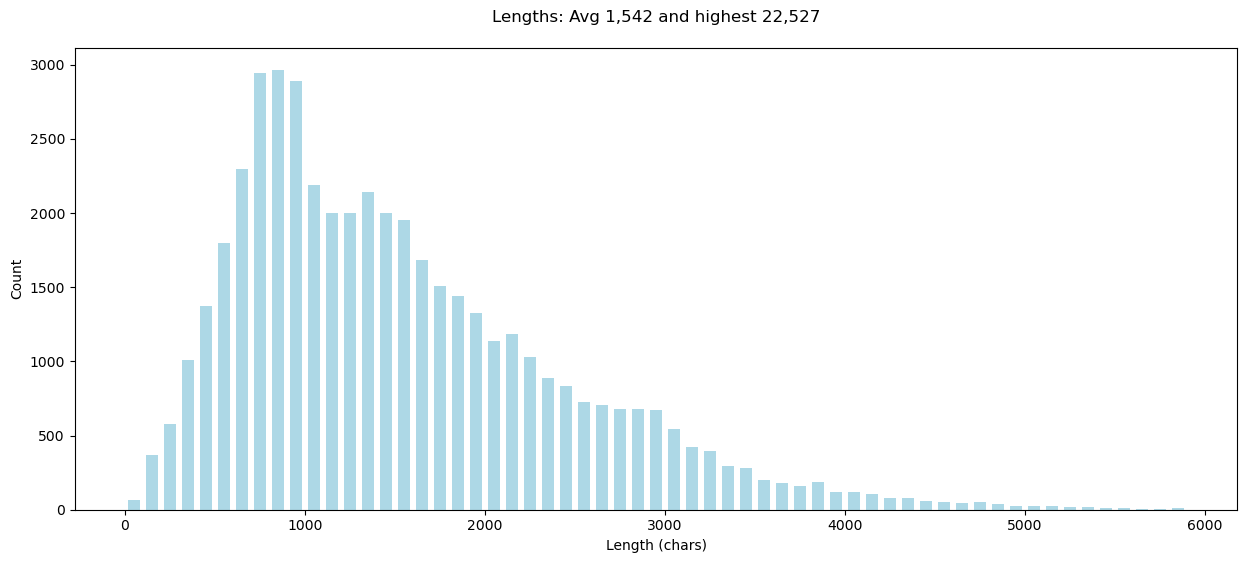

In [15]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

In [16]:
# So what is this item??

for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass

TurboChef BULLET Rapid Cook Electric Microwave Convection Oven


In [17]:
# Create an Item object for each with a price

items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 29,191 items


In [18]:
# Look at the first item

items[1]

<WP67003405 67003405 Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces AP6010352 8208254 PS11743531 - Quick DIY Repair Solution = $16.52>

In [19]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(items[100].prompt)

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $118.00


In [19]:
# Investigate the prompt that will be used during testing - the model has to complete this

print(items[100].test_prompt())

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $


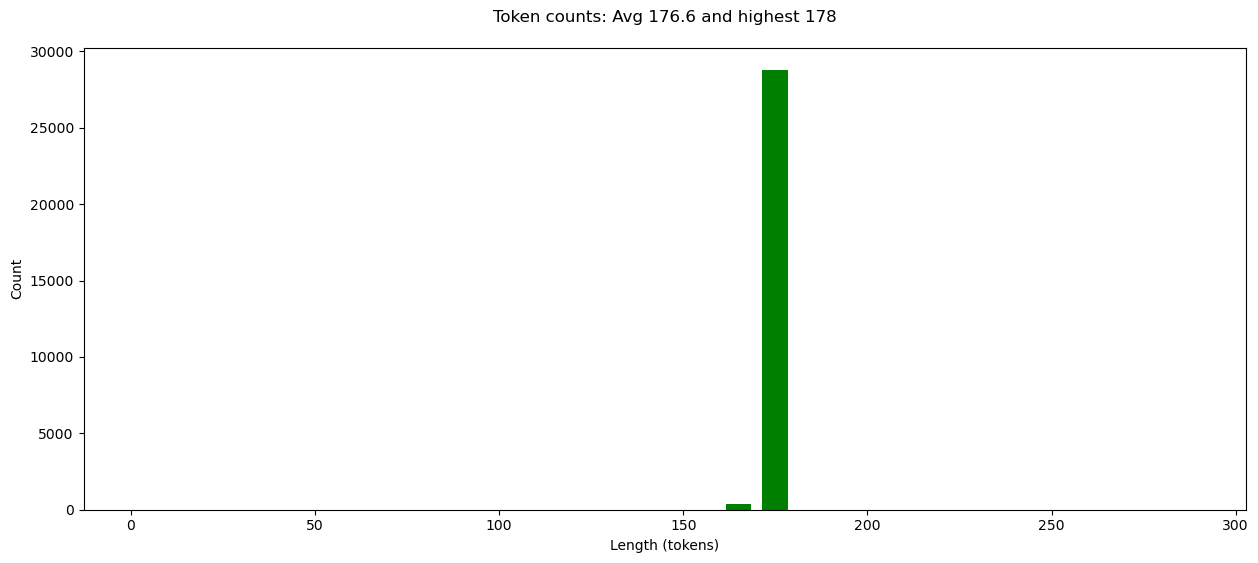

In [20]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

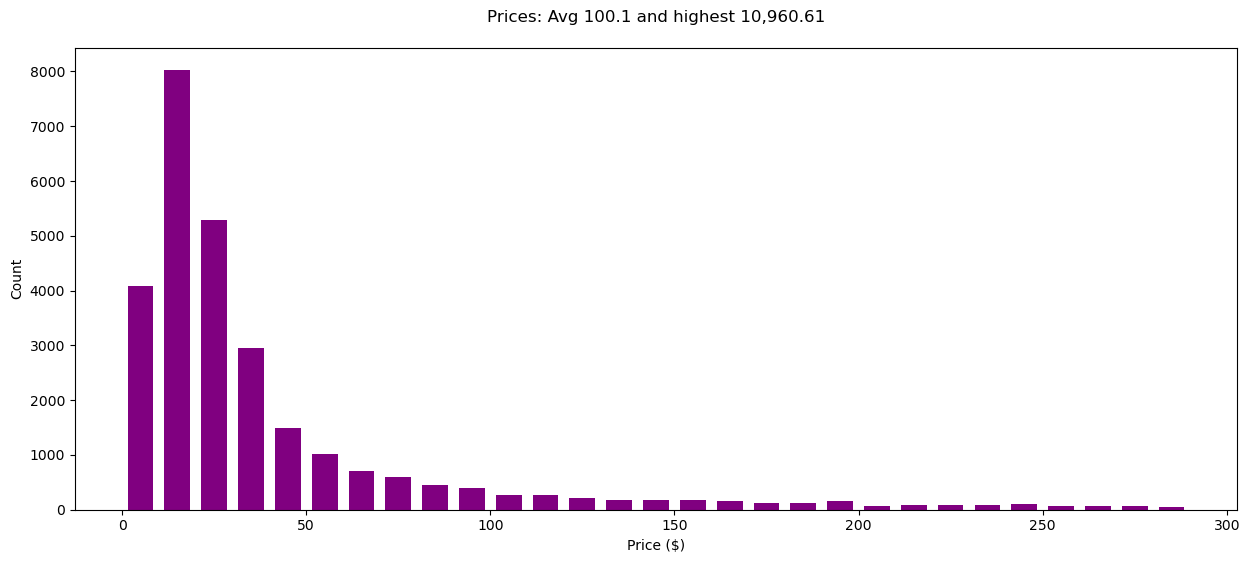

In [21]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

In [22]:
from helpers.loaders import ItemLoader

In [23]:
# Load in the same dataset as last time

items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|██████████| 95/95 [01:38<00:00,  1.04s/it]


Completed Appliances with 28,625 datapoints in 1.7 mins


In [24]:
# Look for a familiar item..
print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


Now to SCALE UP

In [25]:
dataset_names = [
    "Software",
    "Video_Games",
    "Health_and_Personal_Care",
    "Handmade_Products",
    "Appliances",
]

In [26]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load(workers=4))

Loading dataset Software


meta_Software.jsonl:   0%|          | 0.00/256M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 90/90 [00:54<00:00,  1.66it/s]


Completed Software with 14,635 datapoints in 1.4 mins
Loading dataset Video_Games


meta_Video_Games.jsonl:   0%|          | 0.00/437M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 138/138 [03:17<00:00,  1.43s/it]


Completed Video_Games with 49,843 datapoints in 4.2 mins
Loading dataset Health_and_Personal_Care


meta_Health_and_Personal_Care.jsonl:   0%|          | 0.00/118M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 61/61 [00:31<00:00,  1.96it/s]


Completed Health_and_Personal_Care with 4,591 datapoints in 1.0 mins
Loading dataset Handmade_Products


meta_Handmade_Products.jsonl:   0%|          | 0.00/399M [00:00<?, ?B/s]

Generating full split:   0%|          | 0/164817 [00:00<?, ? examples/s]

100%|██████████| 165/165 [03:01<00:00,  1.10s/it]


Completed Handmade_Products with 64,189 datapoints in 4.0 mins
Loading dataset Appliances


100%|██████████| 95/95 [01:30<00:00,  1.05it/s]


Completed Appliances with 28,625 datapoints in 1.6 mins


In [27]:
print(f"A grand total of {len(items):,} items")

A grand total of 161,883 items


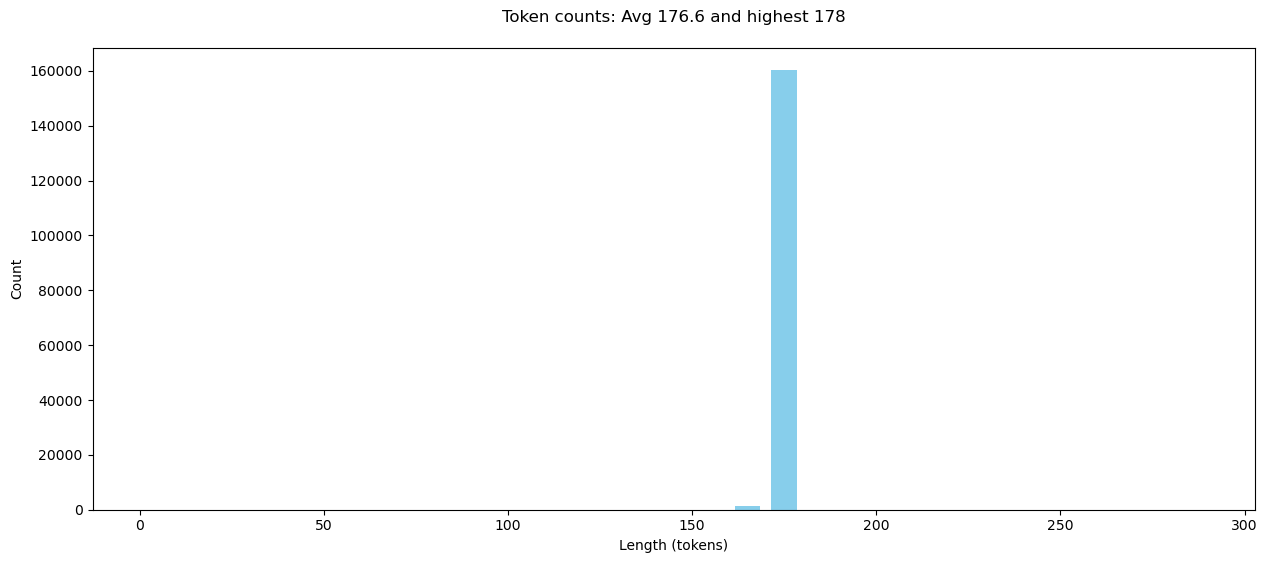

In [28]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

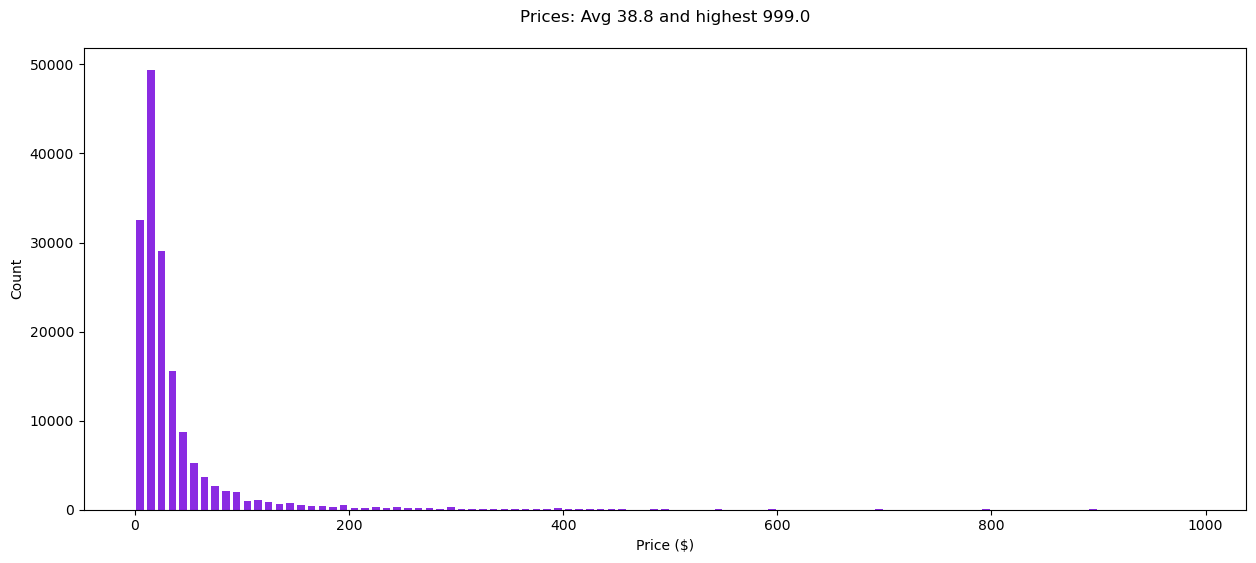

In [29]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

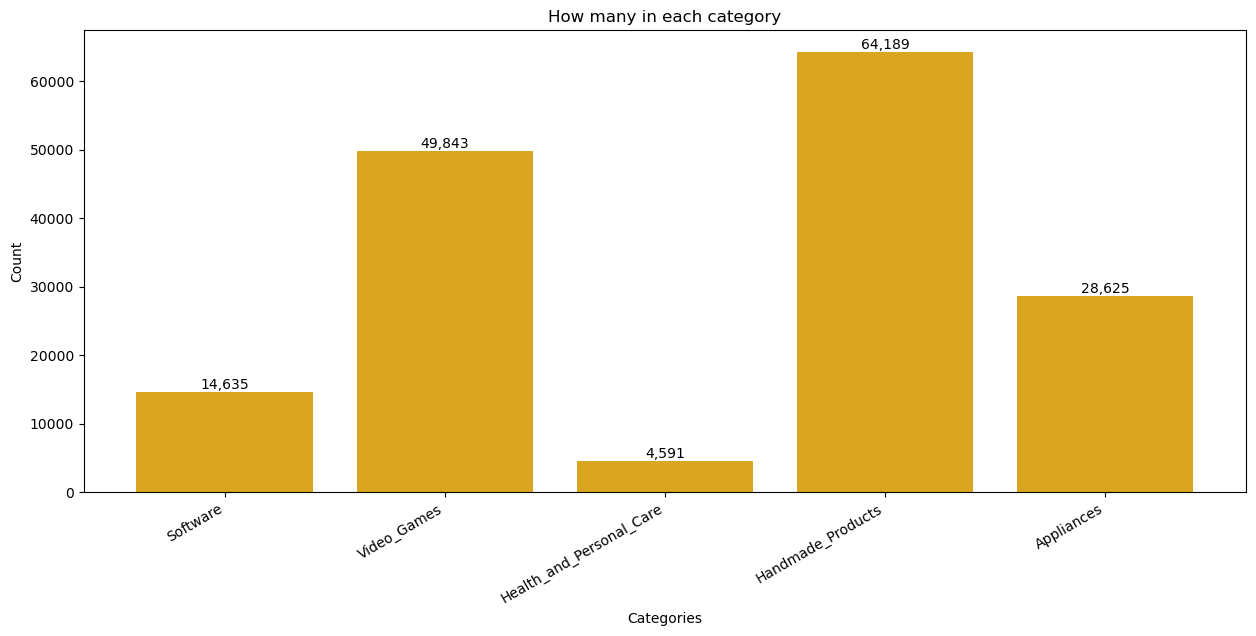

In [31]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

In [35]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [37]:
# Create a dict with a key of each price from $1 to $999
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

# Set target samples per category with higher numbers
# Using roughly proportional targets based on original distribution
TARGET_PER_CATEGORY = {
    'Handmade_Products': 15000,  # Highest in original data
    'Video_Games': 12000,        # Second highest originally
    'Appliances': 8000,          # Third highest
    'Software': 4000,            # Proportional to original
    'Health_and_Personal_Care': 4000  # Proportional to original
}

# Create a dataset called "sample" with more balanced category distribution
np.random.seed(42)
random.seed(42)
sample = []

for i in range(1, 1000):
    slot = slots[i]
    if len(slot) <= 100:  # Increased threshold for keeping all items
        sample.extend(slot)
    else:
        # Group items by category in this price point
        category_items = defaultdict(list)
        for item in slot:
            category_items[item.category].append(item)
        
        # Sample from each category
        for category, target in TARGET_PER_CATEGORY.items():
            items_in_category = category_items[category]
            if items_in_category:
                # Calculate how many items to sample from this category at this price point
                # Using a larger fraction of items per price point
                target_size = min(
                    len(items_in_category),
                    max(2, target // 500)  # Increased items per price point
                )
                
                # Add oversampling for underrepresented categories
                if category in ['Software', 'Health_and_Personal_Care']:
                    target_size = int(target_size * 1.5)  # 50% more sampling for underrepresented categories
                
                selected = np.random.choice(
                    items_in_category, 
                    size=min(target_size, len(items_in_category)), 
                    replace=False
                ).tolist()
                sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

# Print distribution of categories in the final sample
category_counts = defaultdict(int)
for item in sample:
    category_counts[item.category] += 1

print("\nCategory distribution in sample:")
for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{category}: {count:,}")

There are 17,137 items in the sample

Category distribution in sample:
Video_Games: 5,266
Handmade_Products: 4,972
Appliances: 4,805
Health_and_Personal_Care: 1,170
Software: 924


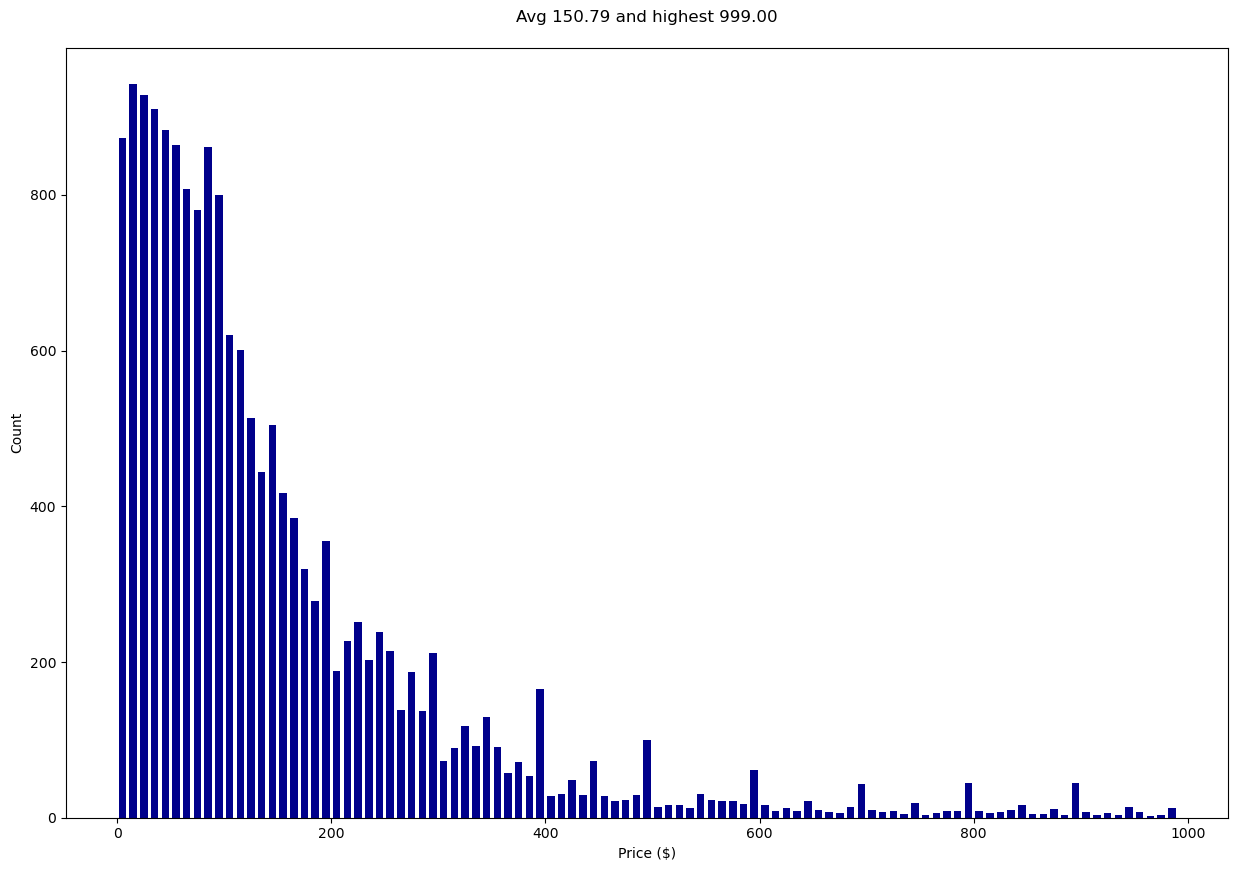

In [38]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

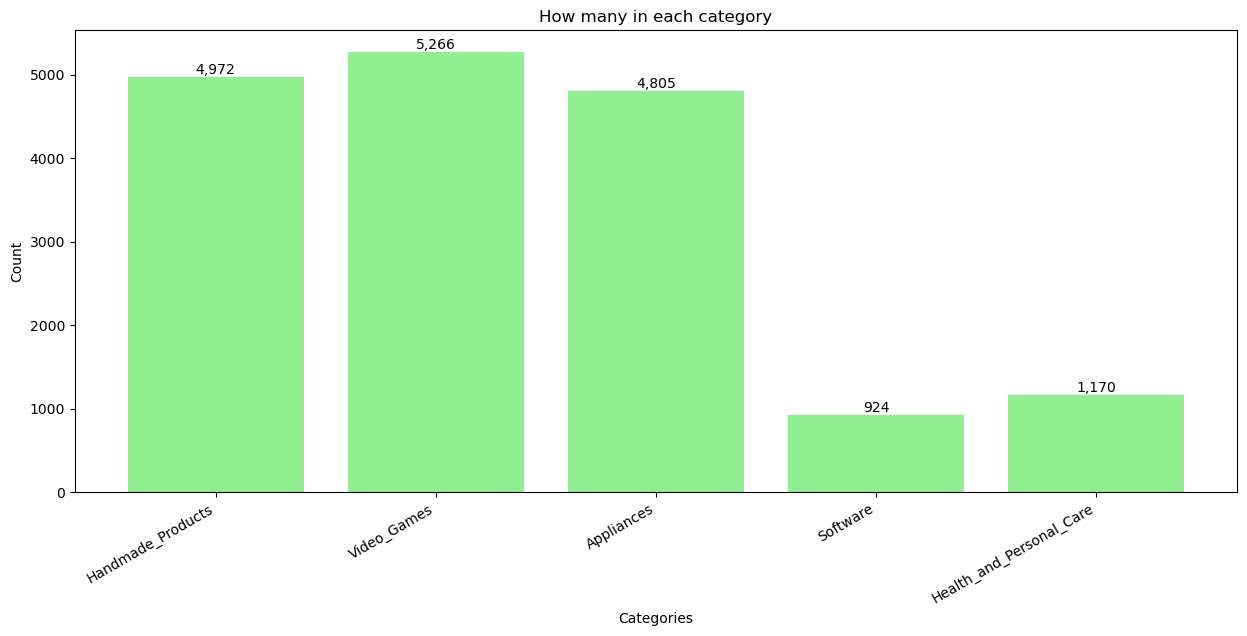

In [39]:
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

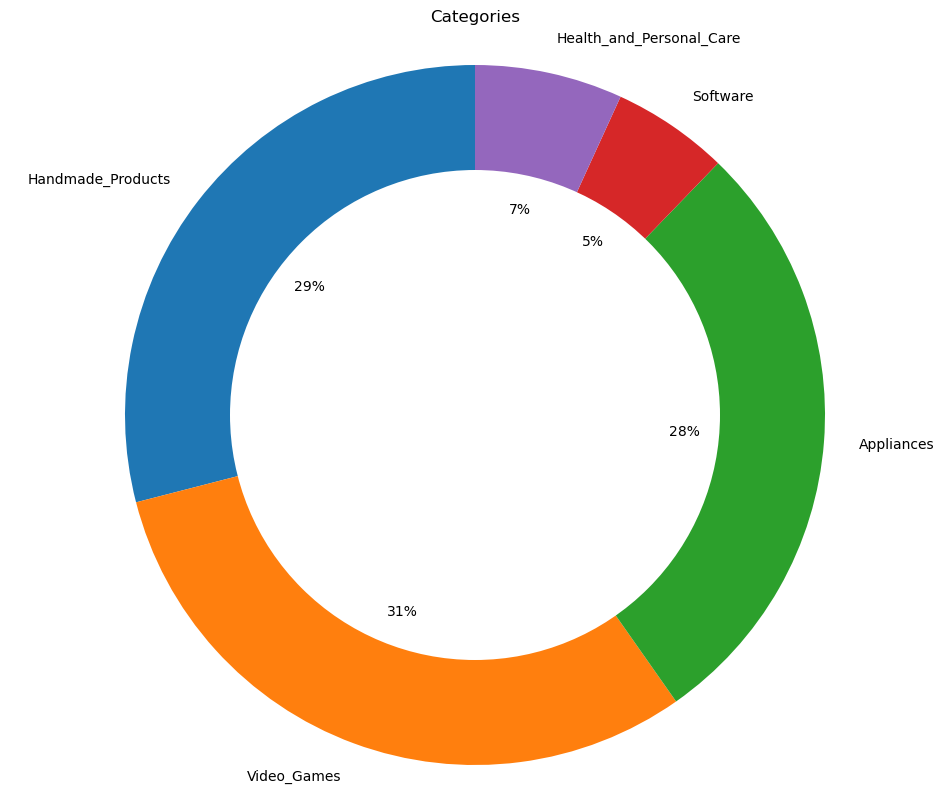

In [40]:
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

Let's do some final checks

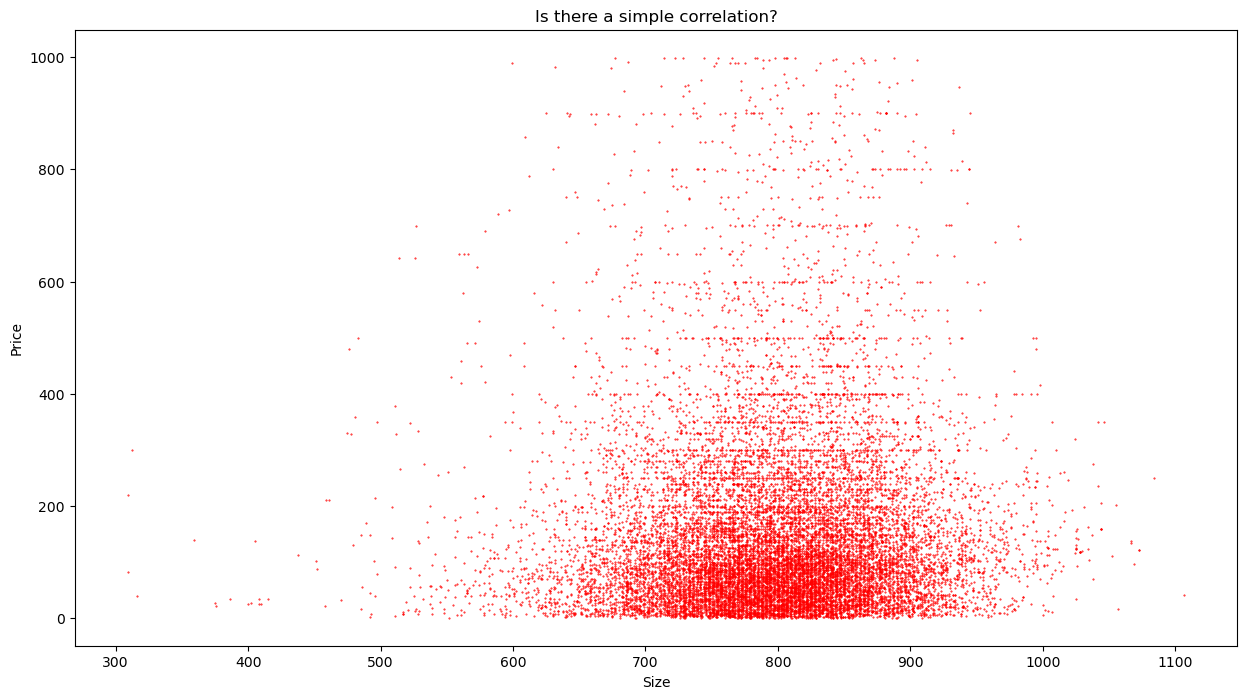

In [41]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [42]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [44]:
report(sample[20])

How much does this cost to the nearest dollar?

Code Word (Saint Squad, #6)
About the Author Originally from Arizona, Traci Hunter Abramson has spent most of her adult life in Virginia. She is a graduate of Brigham Young University and a former employee of the Central Intelligence Agency. Since leaving the CIA, Traci has written several novels, including the Undercurrents trilogy, Royal Target, Royal Secrets, Obsession, and the Saint Squad series. When she's not writing, Traci enjoys spending time with her husband and four children, preferably on a nice, quiet beach. She also enjoys coaching North Stafford High School's swim team. --This text refers to the paperback edition. The media portrayed the military operation as a complete success, but Navy SEAL Jay Wellman wouldn’t describe it that way. He was there. As he

Price is $1.00
[13, 1666, 568, 271, 7117, 374, 400, 16, 13, 410]
['.', ' As', ' he', '\n\n', 'Price', ' is', ' $', '1', '.', '00']


In [45]:
random.seed(42)
random.shuffle(sample)
train = sample[:15000]
test = sample[15000:17137]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 15,000 items and test set of 2,137 items


In [46]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Minneer Racing Steering Simulator Cockpit Red with TV Bracket Mounting Holes Racing Wheel Stand/Fits Logitech G25, G27, G29/ Compatible with Xbox One, Playstation, PC Platforms with Capacity 220LBS
Price Guarantee#：If the price drops within 30 days of purchase, please contact us by email. We will arrange a refund of the price difference for you. Compatible with all racing wheels Thrustmaster, logitech, fanatec; fully customizable. Wide racing seat with thick padding, seat sliders and angle adjustment. Support the front and back adjustment of the seat and adjust the angle of the backrest. Compact, easy to foldable, easy to move, easy to store away. All mounting hardware and tools included. Ready to use right out the

Price is $345.00


In [47]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

The Phantom of the Opera Gaston Leroux Clay Mini Book Key Chain Ring Bag Purse Backpack Clip Snap
“I tore off my mask so as not to lose one of her tears... and she did not run away!” Wouldn't you like a more effective way to keep track of your bag? This clay mini book pendant provides a durable, lightweight accessory to mark your satchel, purse or backpack. Both eye-catching and trendy, the stunning cover makes it easy to locate your belongings. VERSATILE it doubles as a lovely key chain or key ring.Treat yourself to a Book Beads adaptation of a novel which was first serialized in La Gaulois (1909) and remains a musical classic to this day. It's the perfect bookish accessory! HANDMADE IN THE USA when

Price is $


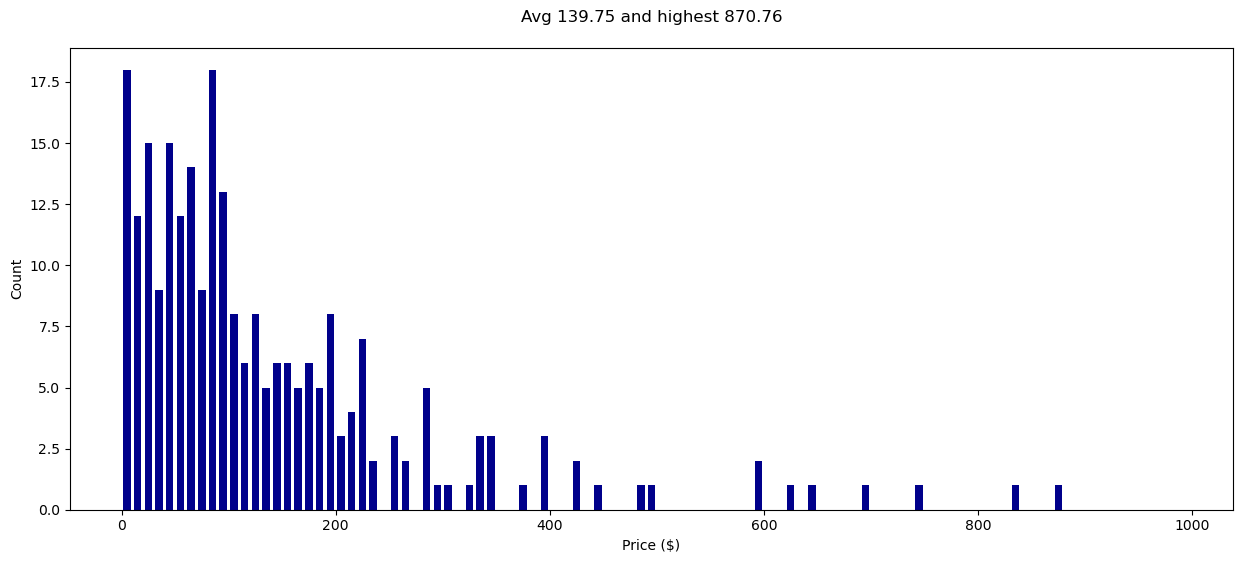

In [48]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [49]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [50]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [51]:
# push to the hub

HF_USER = "hamzabaccouri"
DATASET_NAME = f"{HF_USER}/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/hamzabaccouri/pricer-data/commit/ac1832b34a8b61d969363bb50bdee3418e4bc90e', commit_message='Upload dataset', commit_description='', oid='ac1832b34a8b61d969363bb50bdee3418e4bc90e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/hamzabaccouri/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='hamzabaccouri/pricer-data'), pr_revision=None, pr_num=None)

In [52]:
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)